In [1]:
import json
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sys

In [2]:
catalog = pd.read_csv("/Users/english/code/adotto/regions/adotto_TRregions_v1.1.bed", sep='\t')
catalog.set_index(['chr', 'start', 'end'], inplace=True)
benchmark = pd.read_csv("/Users/english/code/adotto/benchmark/GIABTR_benchmark.6.26/GIABTR.HG002.benchmark.regions.bed.gz",
                        sep='\t', names=['chr', 'start', 'end', 'tier', 'repl', 'var_state', 'entropy', 'mat_ad', 'pat_ad'])
benchmark.set_index(['chr', 'start', 'end'], inplace=True)

In [70]:
len(catalog), len(benchmark), len(benchmark) / len(catalog)

(1784804, 1706853, 0.9563251763218819)

In [8]:
def get_max_motif(x):
    d = json.loads(x)
    return max([_['period'] for _ in d])

data = benchmark[benchmark['tier'] == "Tier1"]
data = data.join(catalog)

data['is_inter'] = data['interspersed'] != '.'

data['max_motif'] = data['annos'].apply(get_max_motif)
data['motif_length_bin'] = pd.cut(data['max_motif'], bins=[2, 8, 20, 50, 100, sys.maxsize], right=False, 
              labels=["[2, 8)", "[9, 20)", "[21,50)", "[51, 100)", ">100"])
data['max_delta'] = data[['mat_ad','pat_ad']].max(axis=1)
hg002_subset = data['var_state'].apply(lambda x: x & 0x1) != 0

real_deltas = pd.read_csv("n_ad.txt", sep='\t', names=["chr", "start", "end", "delta"]).set_index(['chr', 'start', 'end'])
data['real_delta'] = real_deltas
data['approx_copies'] = data['real_delta'] / data['max_motif']

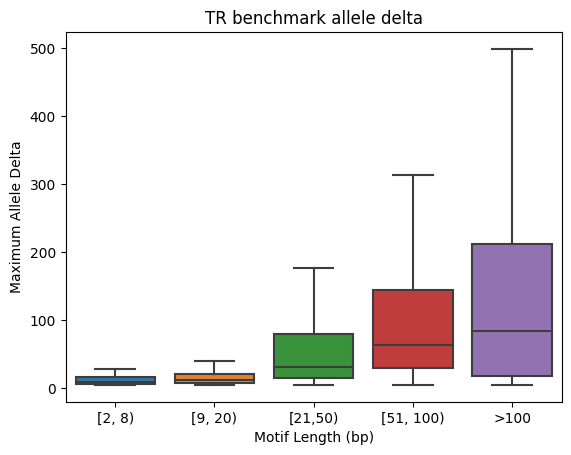

In [24]:
p = sb.boxplot(data=data[hg002_subset & (~data['is_inter'])], x = "motif_length_bin", y="max_delta", showfliers=False)
p.set(title="TR benchmark allele delta",
     xlabel="Motif Length (bp)",
     ylabel="Maximum Allele Delta")
plt.savefig("Figure2C.pdf")

In [ ]:
# There's a general trend that longer motifs create longer expansions/contractions of the region

In [20]:
from scipy.stats import spearmanr, pearsonr

In [22]:
view = data[hg002_subset & ~data['is_inter']]
print(pearsonr(view['max_delta'], view['max_motif']))
print(pearsonr(view['max_delta'], view['motif_length_bin'].cat.codes))

PearsonRResult(statistic=0.15434867208318914, pvalue=0.0)
PearsonRResult(statistic=0.16534644662267095, pvalue=0.0)


In [10]:
view = data[hg002_subset & ~data['is_inter']]
spearmanr(view['max_delta'], view['max_motif'])

SignificanceResult(statistic=0.26935056111555483, pvalue=0.0)

In [18]:
view = data[hg002_subset & ~data['is_inter']]
spearmanr(view['max_delta'], view['motif_length_bin'].cat.codes)

SignificanceResult(statistic=0.3318853734563183, pvalue=0.0)

In [94]:
print((data[hg002_subset & (~data['is_inter'])]['approx_copies'] > 0).sum(),
      (data[hg002_subset & (~data['is_inter'])]['approx_copies'] < 0).sum())

48286 45377


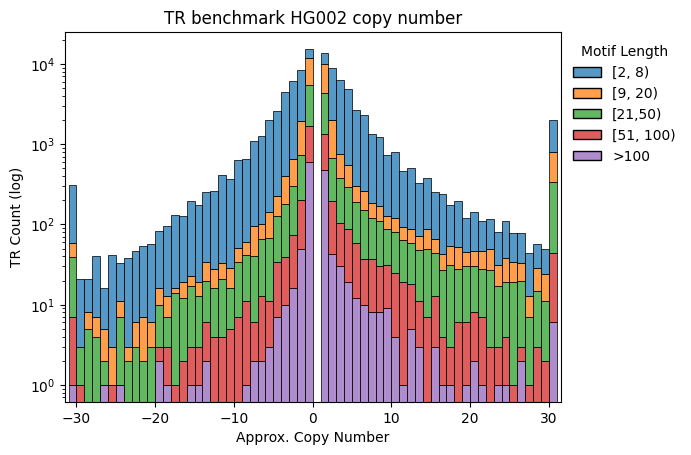

In [44]:
def copy_rounder(x):
    sign = -1 if x < 0 else 1
    mabs = abs(x)
    if mabs < 1:
        return sign * 1
    if mabs > 30:
        return sign * 31
    return round(x)
data['round_copies'] = data['approx_copies'].apply(copy_rounder)

view = data[hg002_subset & (~data['is_inter'])]
p = sb.histplot(data=view, 
                x='round_copies', hue="motif_length_bin", 
                multiple='stack', 
                binwidth=1)
#plt.xticks(ha='right')
p.set(yscale='log', title="TR benchmark HG002 copy number",
     xlabel="Approx. Copy Number",
     ylabel="TR Count (log)", 
      xlim=(-31.5, 31.5))
_ = sb.move_legend(
    p, "upper left",
    bbox_to_anchor=(1, 1), ncol=1, title="Motif Length", frameon=False,
)
plt.savefig("Figure2D.pdf")

# For this we'll be looking for symmetry. 
Though there will be an imbalance at larger allele deltas because contractions are limited to a maximum length of the region's span whereas expansions can continue indefinitley.

[None]

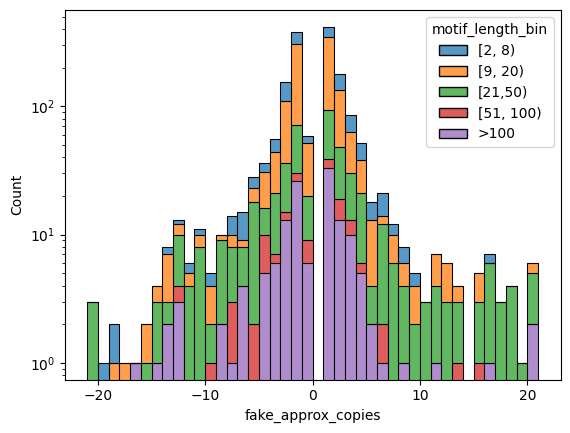

In [96]:
# Why we sometimes want to exclude interspersed repeats
view = data[hg002_subset & (data['approx_copies'].between(1, 21)) & (data['is_inter'])]
p = sb.histplot(data=view, 
                x='fake_approx_copies', hue="motif_length_bin", 
                multiple='stack', 
                binwidth=1)
p.set(yscale='log')

[None]

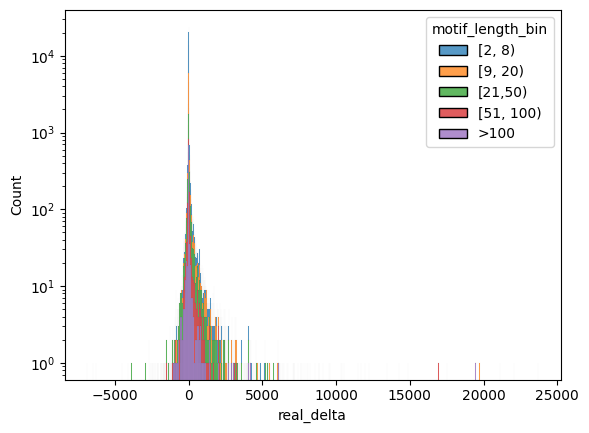

In [99]:
p = sb.histplot(data=data[hg002_subset], x='real_delta', hue='motif_length_bin', binwidth=10, multiple='stack')
p.set(yscale='log')

# Detailing Tiers

In [4]:
data = benchmark.join(catalog)

In [5]:
data['tier'].value_counts()

Tier1    1638508
Tier2      68345
Name: tier, dtype: int64

In [7]:
data[data['tier'] == "Tier1"]['repl'].value_counts()

TN_TN_TN       1518201
TP_TP_TP         98755
_TN_TN           13622
TN__TN            3384
TN_FP_TN           902
TP_FN_TP           780
FP_TN_TN           744
FN_TP_TP           712
_TP_TP             700
TP_FN,FP_TP        260
TP__TP             249
FN,FP_TP_TP        198
TP_UNK_TP            1
Name: repl, dtype: int64

In [17]:
tot = 1518201 + 98755
print(tot, tot / len(data))
print(tot / (data['tier'] == "Tier1").sum())

1616956 0.9473317268681017
0.9868465701723763


In [14]:
j = data[data['repl'].isin(["TN_TN_TN", "TP_TP_TP"])].reset_index()

In [15]:
print("Total span of all agreement Tier1 regions", (j['end'] - j['start']).sum())

Total span of all agreement Tier1 regions 197317916


In [18]:
def find_no_agreement(x):
    return len(set(x.split('_'))) == 3
no_agree = data['repl'].apply(find_no_agreement)

In [21]:
no_agree = no_agree.to_frame().join(data['tier'])

In [24]:
no_agree[no_agree['tier'] == "Tier2"]['repl'].value_counts()

False    67491
True       854
Name: repl, dtype: int64

In [25]:
854 / (data['tier'] == "Tier2").sum()

0.012495427609920258

In [28]:
# Supp Table - Assignment to Tiers
data[['ei', 'li', 'th']] = data['repl'].str.split('_', expand=True)

In [32]:
cnts = data.groupby(['tier', 'repl']).size().reset_index()

In [33]:
cnts[['ei', 'li', 'th']] = cnts['repl'].str.split('_', expand=True)

In [36]:
table = cnts[['tier', 'ei', 'li', 'th', 0]]
table.columns = ["Tier", "TechRepl1", "TechRepl2", "AlignRepl", "Count"]
table.to_csv("SuppTableReplTiers.txt", sep='\t', index=False)

In [38]:
# Variants in benchmark by size
vstate = benchmark['var_state'].value_counts()

In [43]:
has_5bp = vstate[[(_ & 0x1 != 0) for _ in vstate.index]]
has_small = vstate[[(_ & 0x2 != 0) & (_ & 0x1 == 0) for _ in vstate.index]]

In [51]:
has_5bp.sum(), has_5bp.sum() / len(benchmark)

(107842, 0.06318177370869078)

In [52]:
has_small.sum(), has_small.sum() / len(benchmark)

(346935, 0.20326003469543072)

In [46]:
is_neg = vstate[[_ & 0x3 == 0 for _ in vstate.index]]

In [53]:
is_neg.sum(), is_neg.sum() / len(benchmark)

(1252076, 0.7335581915958785)

99

To ensure that the variation captured in the benchmark is representative of variation found across the diverse set of individuals in the pVCF, we compare HG002 variants in Tier1 regions with that found in the other samples

- This is just Tier1, var_flag 0x2 vs 0x4. 
- Then I gotta make a script to do the 98% similarity, too.
  - For Tier1 with variants
  - Make all haplotypes in pVCF (exclude HG002 technical replicates)
  - and calculate the sequence similarity of HG002 to each
  - count how many have >=98% similarity
  - report that count over number of Tier1 with variants

In [60]:
view = data[data['tier'] == 'Tier1']
isHG002 = view['var_state'].apply(lambda x: (x & 0x1) != 0)
isOther = view['var_state'].apply(lambda x: (x & 0x4) != 0)

In [62]:
print('hg002 5bp count', isHG002.sum())
print('other 5bp count', isOther.sum())
print('both 5bp count', (isHG002 & isOther).sum())
print('hg002 exclusive', (isHG002 & ~isOther).sum())
print('other exclusive', (~isHG002 & isOther).sum())

hg002 5bp count 101704
other 5bp count 282408
both 5bp count 101402
hg002 exclusive 302
other exclusive 181006


In [64]:
print('hg002 and other', 101402 / 101704)

hg002 and other 0.9970305985998584


In [66]:
print('lack hg002 but has other', 181006 / len(view))


lack hg002 but has other 0.11047001296301269
